# Causal Attention Mechanism
Or Masked Attention Model and it restricts the model to only consider prevous and current inputs in a sequence when processing any given token

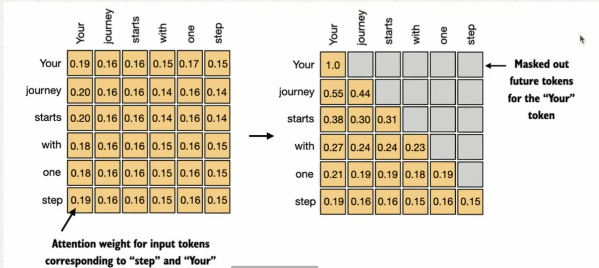

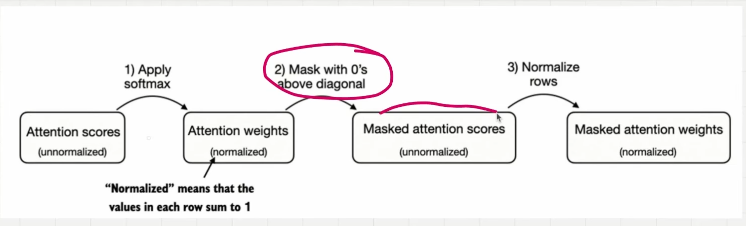

In [4]:
# Input Embedding Matrix
inputs = torch.tensor (
    [[0.43, 0.15, 0.89],  #(x^1) Your
     [0.55, 0.87, 0.66],  #(x^2) journey
     [0.57, 0.85, 0.64],  #(x^3) starts
     [0.22, 0.58, 0.33],  #(x^4) with
     [0.77, 0.25, 0.10],  #(x^5) one
     [0.05, 0.80, 0.55]]  #(x^6) step
)

In [2]:
import torch

In [9]:
dimIn = inputs.shape[1] # Columns(3)
dimOut = 2

In [6]:
import torch.nn as nn

# nn. Linear has more smooth initialization scheme contributing to more stable and effective model training
class selfAttentionV2(nn.Module):
  # Trainable Weight Matrix
  def __init__(self, dimIn, dimOut, qkv_bias = False):
    super().__init__()
    self.wQuery = nn.Linear(dimIn, dimOut, bias = qkv_bias)
    self.wKey = nn.Linear(dimIn, dimOut, bias = qkv_bias)
    self.wValue = nn.Linear(dimIn, dimOut, bias = qkv_bias)

  # Computing Key, Value, Query Matrix (x --> ip) then attention scores, weights and context vectors
  def forward(self, x):
    keysMatrix = self.wKey(x)
    queriesMatrix = self.wQuery(x)
    valuesMatrix = self.wValue(x)

    attentionScores = queriesMatrix @ keysMatrix.T
    attentionWeights = torch.softmax(attentionScores/keysMatrix.shape[-1]**0.5, dim=-1)
    contextVectors = attentionWeights @ valuesMatrix

    return attentionWeights, contextVectors

In [11]:
torch.manual_seed(789)
sa_v2 = selfAttentionV2(dimIn, dimOut)
print(sa_v2(inputs))

(tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>), tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>))


In [13]:
queriesMatrix = sa_v2.wQuery(inputs)
keysMatrix = sa_v2.wKey(inputs)

attentionScores = queriesMatrix @ keysMatrix.T
attentionWeights = torch.softmax(attentionScores/keysMatrix.shape[-1]**0.5, dim=-1)
print(attentionWeights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


# S1) Hiding Future Attention Weights

In [17]:
contextLen = attentionScores.shape[0]
maskSimple = torch.tril(torch.ones(contextLen, contextLen))
print(maskSimple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [19]:
maskedSimple = attentionWeights * maskSimple
print(maskedSimple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


# Dont Normalize Using Softmax

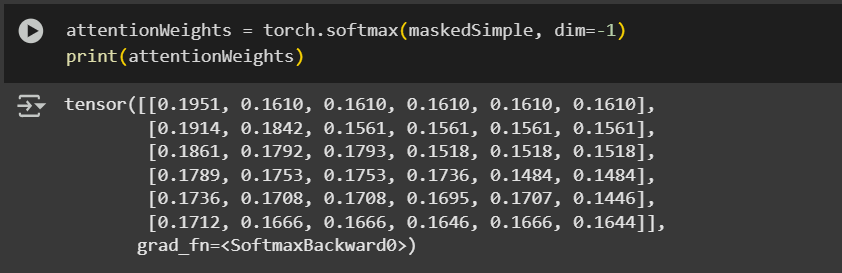

In [22]:
rowSum = maskedSimple.sum(dim = 1, keepdim= True)
maskedSimpleNormalized = maskedSimple / rowSum
print(maskedSimpleNormalized)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


* Aim of the Causal is to prevent any influence of future tokens but in attentionWeightMatrix all the weights are already influenced while it went through normalization this is called "LEAKAGE" Problem

* More Effecient Way
Attention Scores --> Upper Triangular Infinity Mask --> Softmax



In [23]:
print(attentionScores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [30]:
mask = torch.triu(torch.ones(contextLen, contextLen), diagonal = 1)
masked = attentionScores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [32]:
attentionWeightsMatrix = torch.softmax(masked / keysMatrix.shape[-1]**0.5, dim = -1)
print(attentionWeightsMatrix)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


# Masking Additional Weights With Droput
Dropout Prevents OverFitting and imporoves Performance

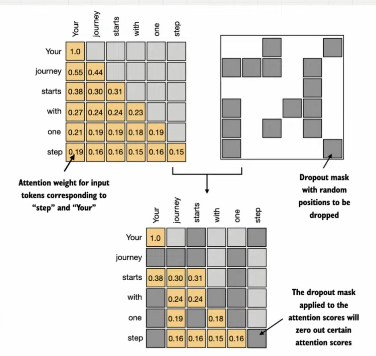

In [35]:
example = torch.ones(6,6)
print(example)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


In [36]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


In [39]:
torch.manual_seed(123)
print(dropout(attentionWeightsMatrix))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


# Causal Mechanism Class
Can Handle Masking, Normalization, Dropout and Batches(Multiple Inputs)

In [42]:
batch = torch.stack((inputs, inputs), dim = 0)
print(batch)
print(batch.shape) # 2 Batches/ Tensor of shape 6(tokens)x3(3 dimensional vector)

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])
torch.Size([2, 6, 3])


In [49]:
class CausalMechanismV1(nn.Module):
  def __init__(self, dimIn, dimOut, contextLen, dropout, qkv_bias=False):
    super().__init__()
    self.dimOut = dimOut
    self.wQuery = nn.Linear(dimIn, dimOut, bias=qkv_bias)
    self.wKey = nn.Linear(dimIn, dimOut, bias=qkv_bias)
    self.wValue = nn.Linear(dimIn, dimOut, bias=qkv_bias)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask', torch.triu(torch.ones(contextLen, contextLen), diagonal=1))

  def forward(self, x):
    batches, numTokens, dimIn = x.shape
    queryMat = self.wQuery(x)
    keyMat = self.wKey(x)
    valueMat = self.wValue(x)

    attentionScoreMatrix = queryMat @ keyMat.transpose(1, 2)
    attentionScoreMatrix.masked_fill_(self.mask.bool()[:numTokens, :numTokens], -torch.inf)
    attentionScoreMat = torch.softmax(attentionScoreMatrix/keyMat.shape[-1]**0.5, dim=-1)
    attentionScoreMat = self.dropout(attentionScoreMat)

    contextVectorMat = attentionScoreMat @ valueMat
    return contextVectorMat

In [51]:
torch.manual_seed(123)
contextLen = batch.shape[1]
caV1 = CausalMechanismV1(dimIn, dimOut, contextLen, 0.5)
print(caV1(batch))
print(caV1(batch).shape)

tensor([[[-0.9038,  0.4432],
         [-0.4368,  0.2142],
         [-0.4849, -0.1341],
         [-0.5834,  0.0081],
         [-0.6219, -0.0526],
         [-0.1417, -0.0505]],

        [[ 0.0000,  0.0000],
         [-1.1749,  0.0116],
         [-0.7733,  0.0073],
         [-0.9140, -0.2769],
         [-0.7679, -0.0735],
         [-0.6749, -0.0984]]], grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 6, 2])
